<h1><center> Predictive statistics on the I-SPY1 Clinical Trial</center></h1>

### 0. Load modules

In [25]:
# import custom modules wrote by julio
import importlib
import seaborn as sns
import pandas as pd
RANDOM_STATE = 42; # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from capstone_01 import clean_data
from capstone_01 import predictive_statistics
from sklearn.model_selection import train_test_split

# reload modules without restartign the kernel (makes development easier)
importlib.reload(clean_data);
importlib.reload(predictive_statistics);

### 1. Prepare Imbalanced Learning pipeline

In [26]:
from sklearn import metrics, tree
from imblearn import over_sampling as os
from imblearn import pipeline as pl

def ADASYN(X,y,classifier, scorer):
    # http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf
    # ADASYN for inbalanced learning, this will over sample the class wit the fewest number of cases
    adasyn = os.ADASYN(random_state=RANDOM_STATE)

    # create pipeline
    pipeline_classifier = pl.make_pipeline(adasyn, classifier)
    
    # optimize over this variable
    train_scores, test_scores, ideal_par = predictive_statistics.validation_curve(pipeline_classifier,
                                                                       X, y, "adasyn__k",scorer,
                                                                       parameter_range = range(1,20),
                                                                       c_v = 5)
    # plot validation                                                                                                             
    predictive_statistics.plot_validation_curve(train_scores, test_scores,
                                     param_range = range(1,20), title = "Validation Curve with ADASYN",
                                                                     xlabel = 'K neighbor', ylabel = 'Kappa') 
    
    # change parameter into optimal value
    pipeline_classifier.set_params(adasyn__k = ideal_par);
    
    return pipeline_classifier
    
def plot_feature_importance(X,labels, TreeClassifier, title =''):
    predictor_num = np.arange(0,X.shape[1]);
    
    importance = TreeClassifier.feature_importances_
    index = np.argsort(importance, axis = 0)
    
    plt.barh(predictor_num, importance[index]);
    plt.yticks(index, labels);
    plt.title(title);
    plt.show()
    

### 2. clean, load, and format data

In [27]:
file = './raw_data/clinical/I-SPY_1_All_Patient_Clinical_and_Outcome_Data.xlsx'
df = clean_data.clean_my_data(file)
X_df = df.iloc[:,0:11]
X_df.head(2)

# allocate age alone (size issue)

# allocate continous predictors
mri_predictors = ['MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
X_mri = df[mri_predictors].values

# allocate clinical predictors
clinical_predictors = ['age','White', 'ER+', 'PR+', 'HR+'];
X_clinical = pd.pandas.get_dummies(df[clinical_predictors], drop_first=True).values

# allocate a single variable X
X = np.concatenate( (X_clinical, X_mri), axis=1)

#
df.head(3)

,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
SUBJECTID,,,,,,,,,,,,,,,,,
1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0
1003,49.83,Yes,Yes,Yes,Yes,No,No,50.0,64.0,54.0,46.0,Yes,2387,2387,0,No,3.0


<h1><center> Prediction of categorical outcomes</center></h1>

## 1.0 Pathological Complete Response (PCR)

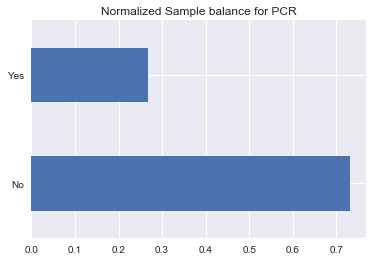

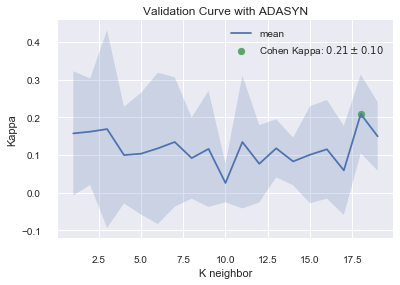

------------------------------------------------------------
Observed Performance
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.81      0.69      0.75        32
          1       0.33      0.50      0.40        10

avg / total       0.70      0.64      0.66        42

------------------------------------------------------------
Performance assuming  41 observations belong to the largest class
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.97      0.85        32
          1       0.00      0.00      0.00        10

avg / total       0.58      0.74      0.65        42



AttributeError: 'LinearSVC' object has no attribute 'feature_importances_'

In [93]:
# allocate  outcome 
outcome = 'PCR'
y = predictive_statistics.labels_to_numbers(df, outcome)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# choose classifier (DecisionTreeClassifier)
clf = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)

# How inbalanced is the sample
df[outcome].value_counts(normalize = True).plot.barh(); plt.title('Normalized Sample balance for ' + outcome);

# optimize using kappa as scorer
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
clf_opt = ADASYN(X,y,clf, scorer)

# train with optimized parameters and predict
clf_opt.fit(X_train, y_train)
yhat = clf_opt.predict(X_test)

# performance
predictive_statistics.classification_report(y_test, yhat)

# what is the importance of each predictor?
labels = clinical_predictors + mri_predictors 
plot_feature_importance(X,labels, clf_opt.steps[1][1],'Feature importance for ' + outcome)

In [94]:
tpr, fpr, thre = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:,1], drop_intermediate = True)
plt.plot(tpr,fpr,'o-')

metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [117]:
def classification_report(y_expected, yhat,X, clf):
    from sklearn.calibration import CalibratedClassifierCV

    index_largest_class = np.argmax(pd.Series(y_expected).value_counts().values)
    index_smallest_class = np.argmin(pd.Series(y_expected).value_counts().values)
    largest_class = pd.Series(y_expected).value_counts().index[index_largest_class]
    small_class = pd.Series(y_expected).value_counts().index[index_smallest_class]

    y_hat_crazy = np.zeros_like(yhat)
    y_hat_crazy[:] = largest_class
    y_hat_crazy[0] = small_class
    size = y_hat_crazy.shape[0] - 1
    
    # Observed
    CF = CalibratedClassifierCV( base_estimator = clf, method='sigmoid', cv=3)
    CF.fit(X,yhat)
    score = CF.predict_proba(X)
    
    tpr, fpr, thre = metrics.roc_curve(y_expected, score[:,1], drop_intermediate= False)

    plt.plot(tpr,fpr,'o-')
    plt.hold
    
    # Crazy 
    tpr, fpr, thre = metrics.roc_curve(y_expected, np.zeros_like(y_test), drop_intermediate=False)
    plt.plot(tpr,fpr,'s-')
    return y_hat_crazy
    
    

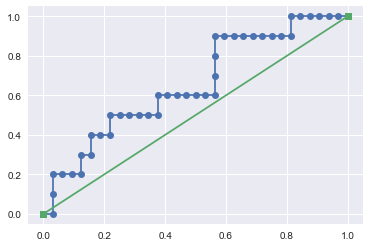

In [118]:
ycrazy = classification_report(y_test, yhat, X_test, clf_opt.steps[1][1])
metrics.roc_curve?


0.59375

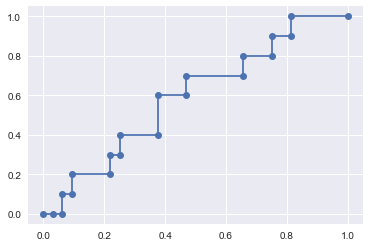

In [95]:
from sklearn.calibration import CalibratedClassifierCV
clf_final = clf_opt.steps[1][1]
CF = CalibratedClassifierCV( base_estimator = clf_final, method='sigmoid', cv=3)
CF.fit(X_train,y_train)
score = CF.predict_proba(X_test)
tpr, fpr, thre = metrics.roc_curve(y_test, score[:,1])
plt.plot(tpr,fpr,'o-')
metrics.roc_auc_score(y_test, score[:,1])

<function matplotlib.pyplot.hold>

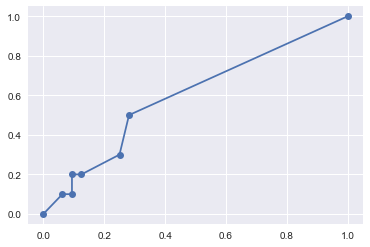

In [72]:
thre

array([ 1.53097209,  0.53097209,  0.42379234,  0.40851411,  0.4005544 ,
        0.30133436,  0.29337465,  0.17091666])

## 2.0  Survival (`Alive`)

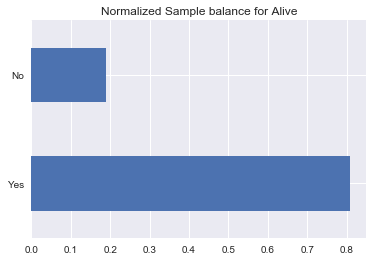

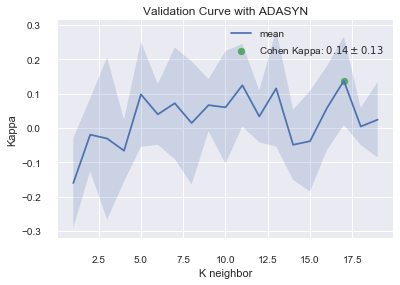

------------------------------------------------------------
Observed Performance
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.78      0.78      0.78        32
          1       0.30      0.30      0.30        10

avg / total       0.67      0.67      0.67        42

------------------------------------------------------------
Performance assuming  41 observations belong to the largest class
------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.97      0.85        32
          1       0.00      0.00      0.00        10

avg / total       0.58      0.74      0.65        42



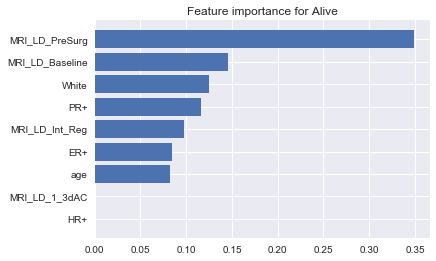

In [5]:
# allocate  outcome 
outcome ='Alive'
y = predictive_statistics.labels_to_numbers(df, outcome)

# How inbalanced is the sample
df[outcome].value_counts(normalize = True).plot.barh(); plt.title('Normalized Sample balance for ' + outcome);

# optimize using kappa as scorer
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

clf_opt = ADASYN(X,y,clf, scorer)

# train with optimized parameters and predict
clf_opt.fit(X_train, y_train)
yhat = clf_opt.predict(X_test)

predictive_statistics.classification_report(y_test, yhat)
# performance
predictor_num = np.arange(0,X.shape[1]);
plot_feature_importance(X,labels, clf_opt.steps[1][1],'Feature importance for ' + outcome)

## 3.0  Recurrence Free Survival (`RFS`, Continous)

In [6]:
# allocate age alone (size issue)

# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
contX = df[cont_predictors].values

# allocate categorical predictors
cat_pred = ['White', 'ER+', 'PR+', 'HR+'];
catX = pd.pandas.get_dummies(df[cat_pred], drop_first=True).values

# predictors
X = np.concatenate( (catX, contX), axis=1)

#outcome
y = df.RFS.values; 
y = y/365

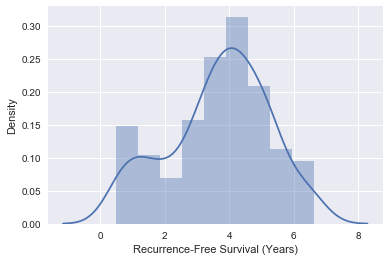

In [7]:
ax = sns.distplot(y, norm_hist = True)
ax.set_xlabel('Recurrence-Free Survival (Years)')
ax.set_ylabel('Density')

### Categorical Predictors only Linear Regression

In [8]:
import statsmodels.api as sm
mae = metrics.median_absolute_error
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# train
OLS = sm.OLS(y_train,X_train).fit() ;
print(OLS.summary())
# test
yhat = OLS.predict(X_test)

# 
mae(y_test, yhat)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     75.85
Date:                Thu, 08 Jun 2017   Prob (F-statistic):           1.28e-44
Time:                        19:48:03   Log-Likelihood:                -233.10
No. Observations:                 126   AIC:                             484.2
Df Residuals:                     117   BIC:                             509.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1183      0.321      0.369      0.7

/Users/Julio/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


1.1293049800977186

In [18]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# optimize using kappa as scorer
scorer = metrics.make_scorer(metrics.median_absolute_error)

# define regressor
regressor =  SVR()

# define parameter grid search
grid = dict( kernel = ['rbf','linear','sigmoid'], 
             C = np.arange(1,11,1),
             epsilon = np.arange(1,11,1),
            gamma = np.linspace(1/10,10,3))
grid_search=  GridSearchCV(  regressor, param_grid = grid, cv= 3, verbose=1, scoring = scorer, n_jobs = 1)

# train
grid_search.fit(X_train, y_train)

# test
sv_reg = grid_search.best_estimator_
sv_reg.predict(X_test)
metrics.median_absolute_error

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed:  1.7min finished


<function sklearn.metrics.regression.median_absolute_error>

In [19]:
metrics.median_absolute_error(sv_reg.predict(X_test), y_test)

1.0438356164383564

In [20]:
sv_reg

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=2,
  gamma=0.10000000000000001, kernel='sigmoid', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
predictive_statistics.